# Why do we need to keep track of logical operators?
One might think that all the logical operators of a rotated surface code might be equivalent, so why would we need to keep track of them? Why does it matter whether the logical Z operator is the first or the second column? 

They are only equivalent up to multiplication by the stabilizers that lie between the two logical operators. This gets relevant when these stabilizer are indeterministic as can happen in a grow or merge. This notebook illustrates how measuring different columns after a grow produces different results and how the right logical operator value can be recovered by multiplying by the readout of the stabilizers lying in between.

In [1]:
from qeclib import (
    RotSurfCode,
    SquareLattice,
    QECPlot,
    PauliNoiseModel,
)
import stim
import numpy as np
import copy

Create the logical qubit objects and place them on the square lattice. Then initialize them in some state. Feel free to change the initial states and observe how the results of the logical QST change.

In [2]:
Q1 = RotSurfCode(
    id="Q1",
    dx=3,
    dz=3,
)

circ = SquareLattice(name="", rows=6, cols=7)
circ.add_logical_qubit(Q1, start_pos=(1,1))
circ.init("Q1", "0")

We can also plot the stabilizers of the two logical qubits to check whether they were correctly placed on the lattice:

In [3]:
qecplot = QECPlot(circ)
qecplot.plot_logical_qubit("Q1")
qecplot.show()

Now we add syndrome extraction cycles for both logical qubits:

In [4]:
uuids_before_grow = (
    circ.add_par_def_syndrome_extraction_circuit_all_log_qbs()
)

Grow

In [5]:
circ.grow("Q1", 2, "r")

In [6]:
uuids_after_grow = (
    circ.add_par_def_syndrome_extraction_circuit_all_log_qbs()
)

In [7]:
qecplot = QECPlot(circ)
qecplot.plot_logical_qubit("Q1")
qecplot.show()

# Plot the circuit using stim
To verify that we have the syndrome extraction circuit that we want, we can plot the circuit using stim:

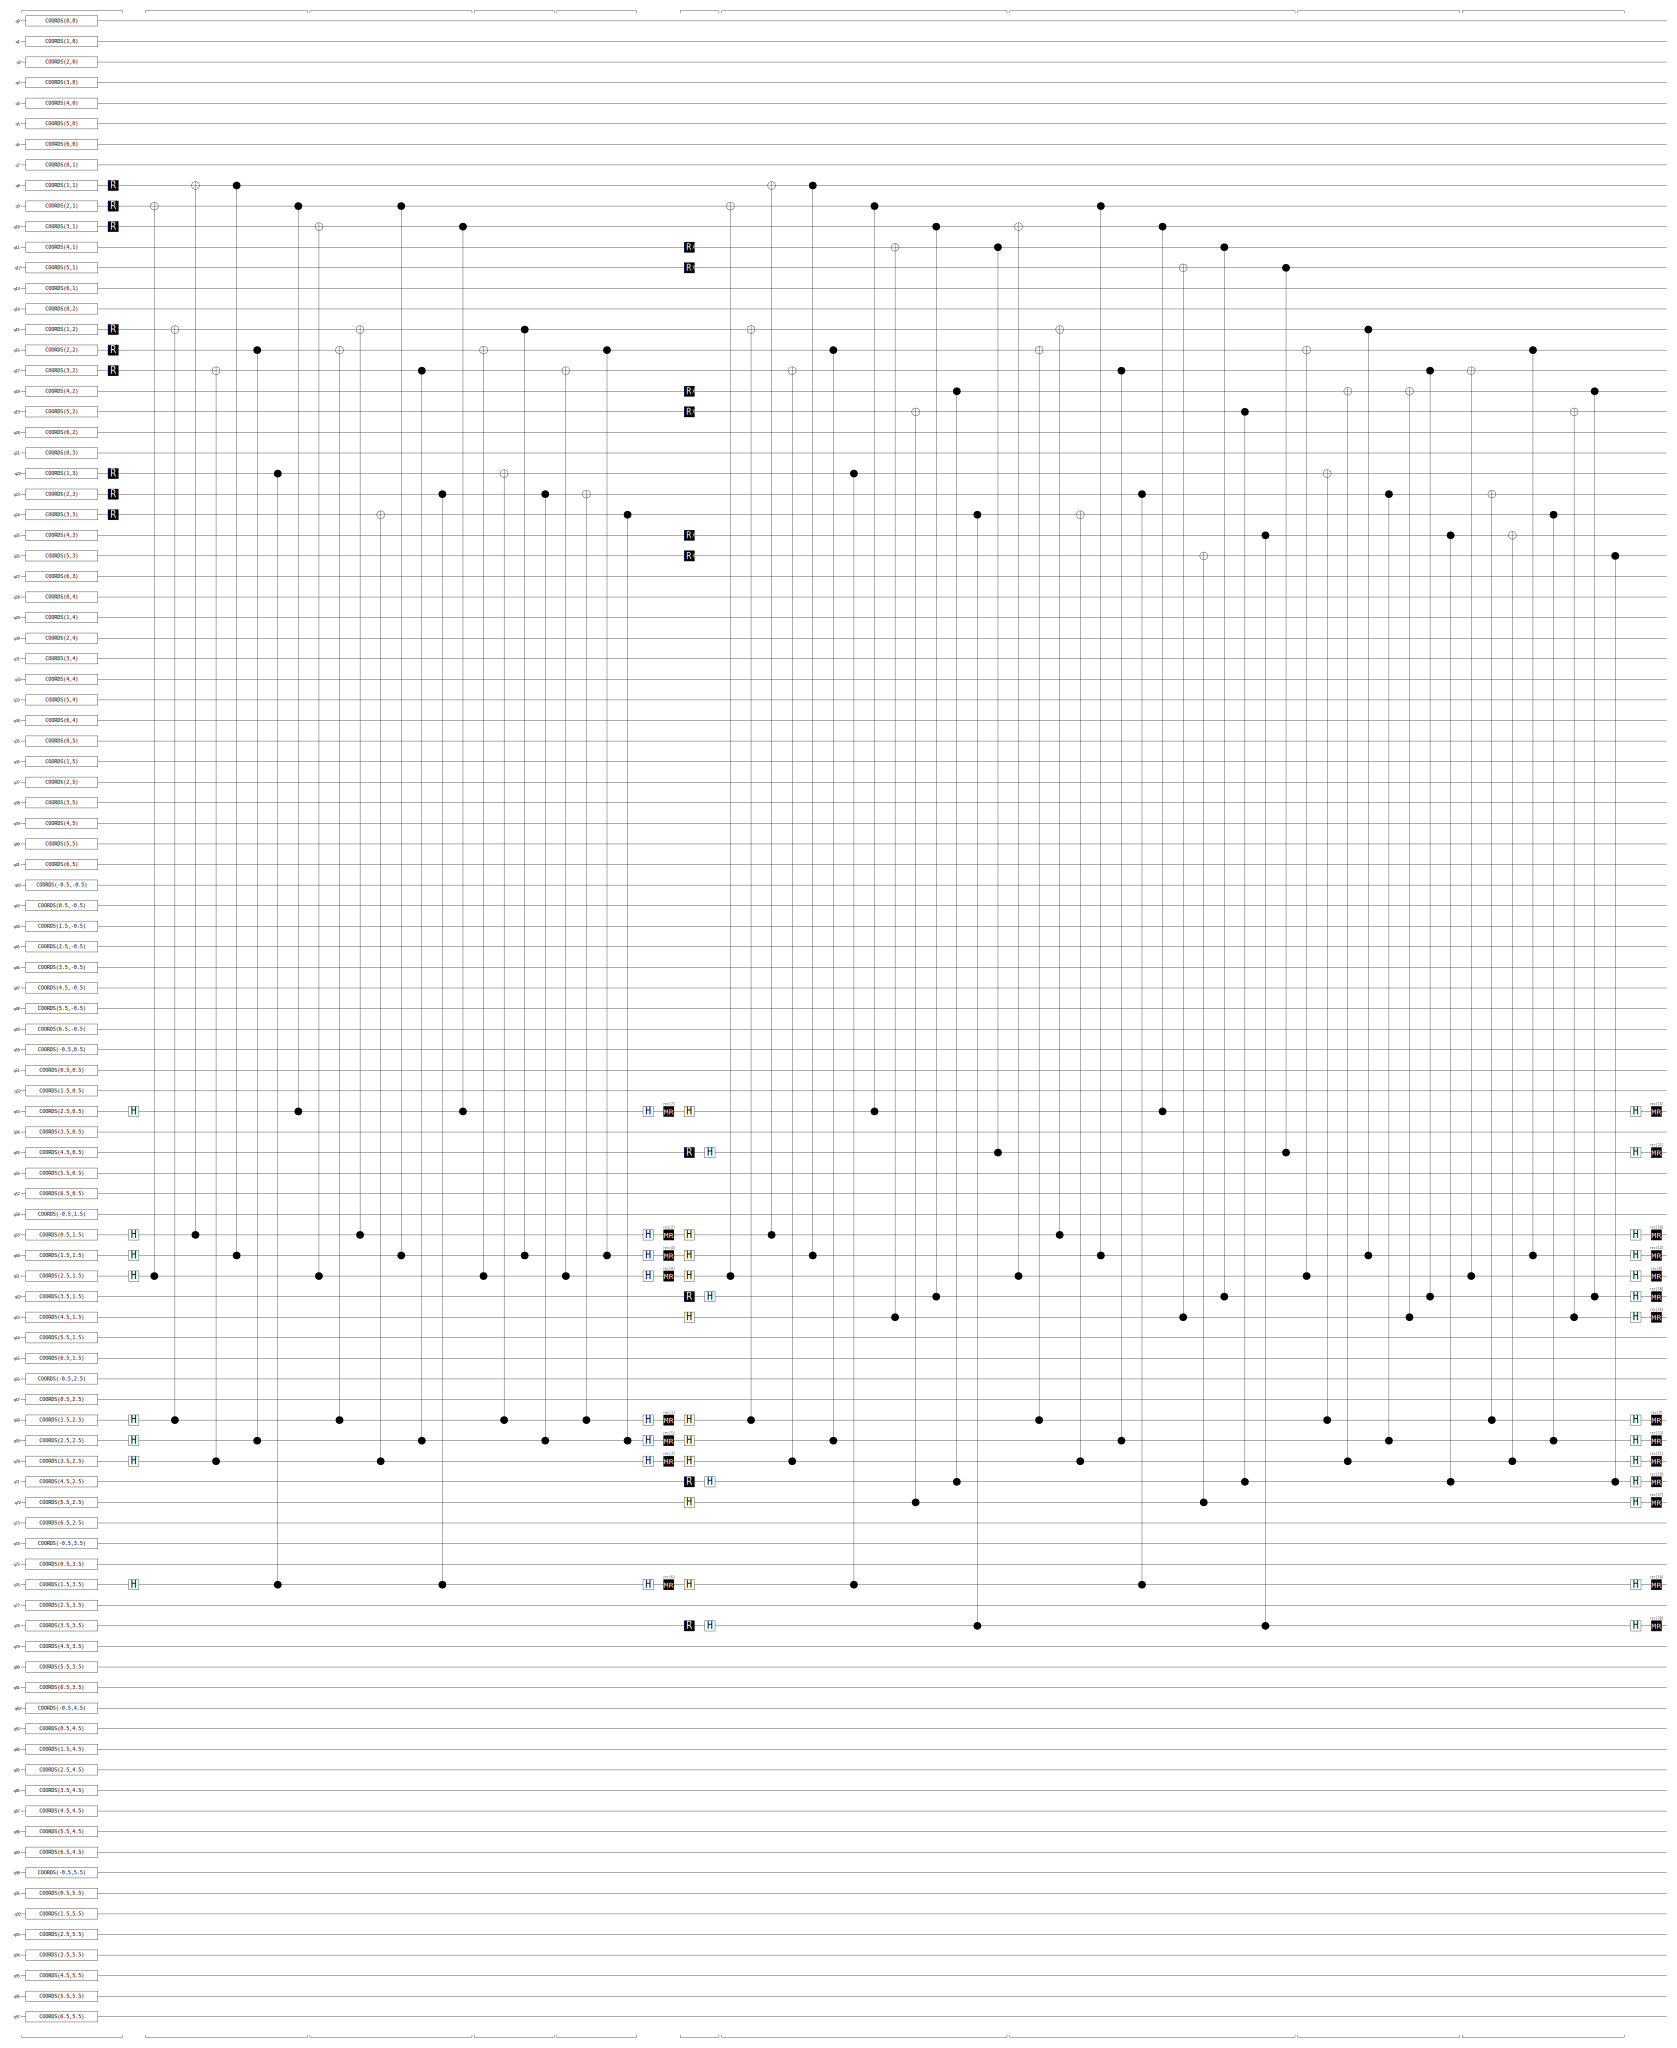

In [8]:
stim.Circuit(circ.convert_to_stim()).diagram(type="timeline-svg")

# Noise model

In [9]:
# Define a noise model
p = 0.001
noise_model = PauliNoiseModel(p=p, p_2q=p, p_reset=p, p_mmt=p)

num_shots = 1000

# Measure the right operator

In [10]:
circ_measure_right_Z = copy.deepcopy(circ)
m_uuid = circ_measure_right_Z.measure_physical_qbs([(1,1,0), (1,2,0), (1,3,0)])

res = (
    stim.Circuit(circ_measure_right_Z.convert_to_stim(noise_model=noise_model))
    .compile_sampler()
    .sample(num_shots)
)
result_bits = []
for r in res:
    mmts = circ_measure_right_Z.dict_m_uuids_to_res(r)
    result_bits.append(np.sum(np.array(mmts[m_uuid], dtype=int)) % 2)

exp_val = np.average(result_bits), np.std(result_bits) / np.sqrt(num_shots)
print(f"<Z> = {exp_val[0]} +/- {np.round(exp_val[1], 2)}")

<Z> = 0.013 +/- 0.0


# Measure the wrong operator
Measuring the last column which exists only after the grow results in a random outcome:

In [11]:
circ_measure_wrong_Z = copy.deepcopy(circ)
m_uuid = circ_measure_wrong_Z.measure_physical_qbs([(5,1,0), (5,2,0), (5,3,0)])

res = (
    stim.Circuit(circ_measure_wrong_Z.convert_to_stim(noise_model=noise_model))
    .compile_sampler()
    .sample(num_shots)
)
result_bits = []
for r in res:
    mmts = circ_measure_wrong_Z.dict_m_uuids_to_res(r)
    result_bits.append(np.sum(np.array(mmts[m_uuid], dtype=int)) % 2)

exp_val = np.average(result_bits), np.std(result_bits) / np.sqrt(num_shots)
print(f"<Z> = {exp_val[0]} +/- {np.round(exp_val[1], 2)}")

<Z> = 0.486 +/- 0.02


# Measure the wrong operator but correct it with the right stabilizers
If we measure again the last column, and we multiply the result by the newly added stabilizers, we recover the original value:

In [12]:
circ_measure_wrong_Z_but_correct = copy.deepcopy(circ)
m_uuid = circ_measure_wrong_Z_but_correct.measure_physical_qbs([(5,1,0), (5,2,0), (5,3,0)])

res = (
    stim.Circuit(circ_measure_wrong_Z_but_correct.convert_to_stim(noise_model=noise_model))
    .compile_sampler()
    .sample(num_shots)
)

correction_stabs = [
    'Z_(3, 1, 0)Z_(4, 1, 0)Z_(3, 2, 0)Z_(4, 2, 0)',
    'Z_(4, 2, 0)Z_(5, 2, 0)Z_(4, 3, 0)Z_(5, 3, 0)',
    'Z_(3, 3, 0)Z_(4, 3, 0)',
    'Z_(4, 1, 0)Z_(5, 1, 0)',
]

correction_uuids = []

for mmt in circ_measure_wrong_Z_but_correct._m_list:
    if mmt.index > 7 and mmt.related_obj in correction_stabs:
        correction_uuids.append(mmt.uuid)

result_bits = []
for r in res:
    mmts = circ_measure_wrong_Z_but_correct.dict_m_uuids_to_res(r)
    final_val = np.sum(np.array(mmts[m_uuid], dtype=int))
    for correction_uuid in correction_uuids:
        final_val += np.array(mmts[correction_uuid], dtype=int)
    result_bits.append(final_val % 2)

exp_val = np.average(result_bits), np.std(result_bits) / np.sqrt(num_shots)
print(f"<Z> = {exp_val[0]} +/- {np.round(exp_val[1], 2)}")

<Z> = 0.028 +/- 0.01
